In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import tabulate

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`


In [4]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                       vusecols=columns)
    df = df.rename(columns=columns)
  return df

### Get linear regression coefficients ($b_0$ and $b_1$)

In [5]:
def get_regress_coeff(df):
  df["XY"] = df['X'] * df['Y']
  df["X^2"] = df['X']**2

  n = len(df)
  sumXY = df["XY"].sum()
  sumX = df["X"].sum()
  sumY = df["Y"].sum()
  sumXsq = df["X^2"].sum()

  b1 = (n*sumXY - sumX*sumY) / (n*sumXsq - sumX**2)
  b0 = sumY/n - b1*sumX/n

  # print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
  return [b0, b1], df


## Load the data

In [6]:
filename = "05-table-01-milk-gallons.ods"

df = read_ods(filename)

df

,Week,"Weekly Sales Level, Y (1,000s of gallons)",Selling Price X ($)
0,1,10,1.3
1,2,6,2.0
2,3,5,1.7
3,4,12,1.5
4,5,10,1.6
5,6,15,1.2
6,7,5,1.6
7,8,12,1.4
8,9,17,1.0
9,10,20,1.1


## Compute least squares coefficients ($b_1$ and $b_0$)

$$
\begin{gather*}
  b_1 = \frac{n \sum XY - \sum X \sum Y}{n \sum X^2 - (\sum X)^2} \\[12pt]
  b_0 = \frac{\sum Y}{n} - \frac{b_1 \sum X}{n}
\end{gather*}
$$

In [7]:
df_corr = df.copy()

# rename the corresponding X and Y column
df_corr = df_corr.rename(columns={
  "Weekly Sales Level, Y (1,000s of gallons)": 'Y',
  "Selling Price X ($)": 'X'})

[b0, b1], df_corr = get_regress_coeff(df_corr)

print(f"(b0, b1) = ({b0:.2f}, {b1:.2f})")
df_corr

(b0, b1) = (32.14, -14.54)


,Week,Y,X,XY,X^2
0,1,10,1.3,13.0,1.69
1,2,6,2.0,12.0,4.00
2,3,5,1.7,8.5,2.89
3,4,12,1.5,18.0,2.25
4,5,10,1.6,16.0,2.56
5,6,15,1.2,18.0,1.44
6,7,5,1.6,8.0,2.56
7,8,12,1.4,16.8,1.96
8,9,17,1.0,17.0,1.00
9,10,20,1.1,22.0,1.21


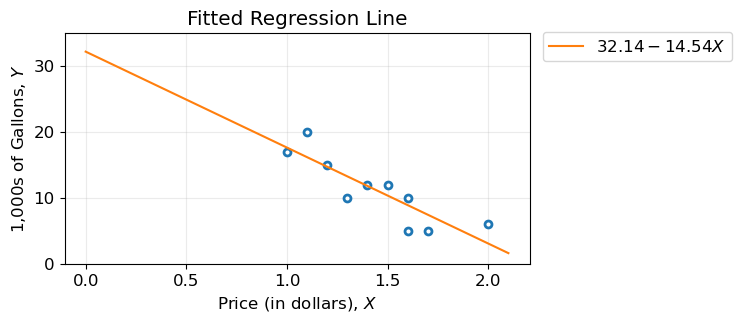

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))


ax.plot(df_corr["X"], df_corr["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

x_regress = np.linspace(0, 2.1)
ax.plot(x_regress, b0 + b1*x_regress, 
  linestyle='-',
  label=r"${:.2f}{:.2f}X$".format(b0, b1)) 

ax.set_ylim([0, 35])

ax.set_xlabel(r"Price (in dollars), $X$")
ax.set_ylabel(r"1,000s of Gallons, $Y$")
ax.set_title("Fitted Regression Line")

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

## Residual Plots

There is an implementation of Minitab's normal probability plot in Python, 
see [this link](https://stackoverflow.com/questions/31174139/python-recreate-minitab-normal-probability-plot?noredirect=1&lq=1)    
But, we don't use that kind of y-scaled format because it used nested classes
and it violates my coding style to avoid nested class. 
I will consider to use it if I have a time to rewrite without nested class.

In [45]:
df_residual = df_corr.copy()
df_residual = df_residual.drop(columns=['XY', 'X^2'])
df_residual['hat_Y'] = b0 + b1*df_residual['X']
df_residual['Y-hat_Y'] = df_residual['Y'] - df_residual['hat_Y']

# To plot a normal probability plot (Q-Q plot)
num_of_samples = len(df_residual)
idx = np.arange(1, num_of_samples+1)
df_residual['sort(Y-hat_Y)'] = np.sort(df_residual['Y-hat_Y'])
df_residual['eCDF'] = (idx-0.5)/num_of_samples   # empirical CDF

df_residual

,Week,Y,X,hat_Y,Y-hat_Y,sort(Y-hat_Y),eCDF
0,1,10,1.3,13.235437,-3.235437,-3.873786,0.05
1,2,6,2.0,3.058252,2.941748,-3.235437,0.15
2,3,5,1.7,7.419903,-2.419903,-2.419903,0.25
3,4,12,1.5,10.327670,1.672330,-0.597087,0.35
4,5,10,1.6,8.873786,1.126214,0.218447,0.45
5,6,15,1.2,14.689320,0.310680,0.310680,0.55
6,7,5,1.6,8.873786,-3.873786,1.126214,0.65
7,8,12,1.4,11.781553,0.218447,1.672330,0.75
8,9,17,1.0,17.597087,-0.597087,2.941748,0.85
9,10,20,1.1,16.143204,3.856796,3.856796,0.95


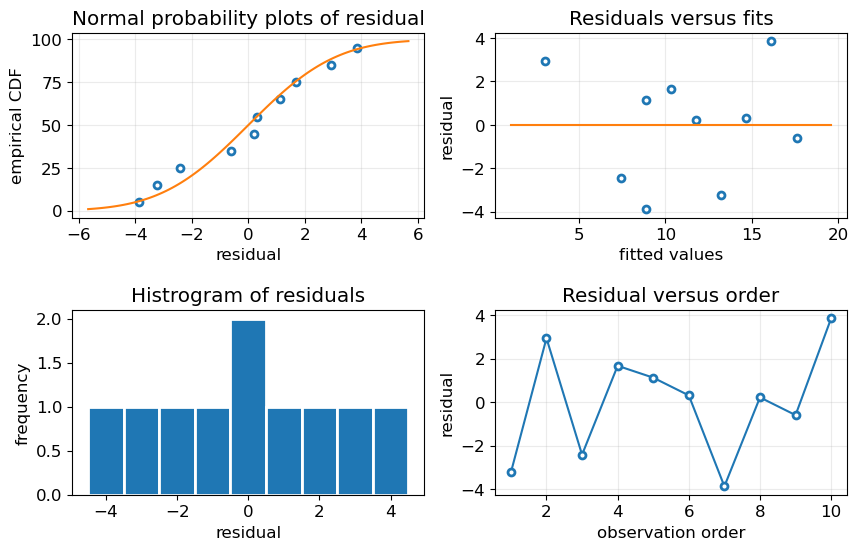

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

significance_lvl = 0.02

# -- Normal probability plot of residual
axes[0, 0].plot(df_residual['sort(Y-hat_Y)'], 
  df_residual['eCDF']*100,
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

mean_residual = df_residual['Y-hat_Y'].mean()
std_residual = df_residual['Y-hat_Y'].std(ddof=0)   # population std; divisior is N

un_z_score_min = sc_stats.norm.ppf(significance_lvl/2, 
  loc=mean_residual, scale=std_residual)
un_z_score_max = sc_stats.norm.ppf(1-significance_lvl/2,
  loc=mean_residual, scale=std_residual)

x_un_z_score = np.linspace(un_z_score_min, un_z_score_max, 100)
y_un_z_score_p_i = sc_stats.norm.cdf(x_un_z_score, loc=mean_residual, scale=std_residual) 
axes[0, 0].plot(x_un_z_score, y_un_z_score_p_i*100)

axes[0, 0].set_xlabel('residual')
axes[0, 0].set_ylabel('empirical CDF')
axes[0, 0].grid("on")
axes[0, 0].set_title("Normal probability plots of residual")


# -- Residual vs. fit
axes[0, 1].plot(df_residual['hat_Y'], df_residual["Y-hat_Y"],
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

x_offset = 2
x_zero_residual_min = df_residual['hat_Y'].min()-x_offset
x_zero_residual_max = df_residual['hat_Y'].max()+x_offset
axes[0, 1].plot([x_zero_residual_min, x_zero_residual_max], [0, 0])

axes[0, 1].set_xlabel("fitted values")
axes[0, 1].set_ylabel("residual")
axes[0, 1].set_title("Residuals versus fits")
axes[0, 1].grid("on")


# -- Histrogram of Residuals
bin_min = int(np.floor(df_residual['Y-hat_Y'].min()))
bin_max = int(np.ceil(df_residual['Y-hat_Y'].max()))
bins = np.arange(bin_min, bin_max+2) - 0.5
axes[1, 0].hist(df_residual["Y-hat_Y"], bins=bins, rwidth=1, density=False, 
  edgecolor='white', linewidth=2)

axes[1, 0].set_xlabel("residual")
axes[1, 0].set_ylabel("frequency")
axes[1, 0].set_title("Histrogram of residuals")



# -- Residual vs. order
axes[1, 1].plot(df_residual['Week'], df_residual['Y-hat_Y'], 
  marker='o', markerfacecolor='white', linewidth=1.5,
  markeredgewidth=2, markersize=5)

axes[1, 1].grid("on")
axes[1, 1].set_xlabel("observation order")
axes[1, 1].set_ylabel("residual")
axes[1, 1].set_title("Residual versus order")


plt.subplots_adjust(hspace=0.5)
plt.show(fig)

For the normal probability plot, all the points of residuals lie nearly along the CDF of normal distribution. This plot suggests there is no reason to doubt the assumption that the residual follows the pattern of normal distribution.

For the plot of residual againts the fitted values, the spread about zero in the vertical direction should be about the same for all values of fitted values. That is, the magnitudes of the residuals for small fitted values should be about the same as the magnitudes of the residuals for intermediate fitted values and about the same as the magnitudes of the residuals for large fitted values.   
This ideal behaviour suggest two things:  
(1) the underlying relation between $Y$ and $X$ is linear, and   
(2) the error variability is constant ($Y$'s at different values of $X$ have the same spread about the regression line)

The plot of residuals versus the fitted values not "bowed" to the rule of a string of positive residuals followed by a string of negative residuals followed by a string of positive residuals. If this is true, the residual would have a behaviour of a nonlinear relation between $Y$ and $X$. This plot also does not have the cone-shaped appearance which indicates nonconstant (increasing) variability.

For the histogram plot, the normal assumption appears to be reasonable even though it only has 10 observations.    

Although the $Y$'s are weekly sales of milk, the weeks were selected at random and were not ordered in time. Consequently, plotting the residual over time or computing the residual autocorrelations was not appropriate.

